<a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group03/blob/main/Presentations/02-MobileNet/Assignment_MobileNet_EuroSAT_alpha75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course**: Deep Learning | Presentation: MobileNet on EuroSAT

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp) 


**Group:** 03

Students: Fabian Linkerhägner | Yu-Chuan Cheng

#-------------------------------------------------------------------------------

## **Procedure for this assignment:**


### *1) Preparations*
#### *--- 1.1) Mounting google drive*
#### *--- 1.2) Import of required packages*
#### *--- 1.3) Initialize important parameters*
----
### *2) Load the dataset*
#### *--- 2.1) Define transformation helper function*
#### *--- 2.2) Define transformations*
#### *--- 2.3) Loading and splitting the dataset*
#### *--- 2.4) Generating iterators for the datasets*
----
### *3) Define the CNN network architecture*
----
### *4) Train the CNN model*
#### *--- 4.1) Initialization of the model*
#### *--- 4.2) Training loop*
----
### *5) Evaluating the model using test dataset*
----
### *6) Plotting the results and saving model*
#### *--- 6.1) Saving the model*
#### *--- 6.2) Plotting loss*
#### *--- 6.3) Plotting accuracy*

#-------------------------------------------------------------------------------

# 1) Preparations

### 1.1) Mounting google drive

In [53]:
#@title
# mount google drive on google colab
print("[Info] Mounting google drive...\n")
from google.colab import drive

drive.mount('/content/drive')

print("\n[Info] Google drive mounted.")

# change to DeepLearning directory
print("\n[Info] Changing current working directory...\n")

%cd /content/drive/MyDrive/DeepLearning/

print("\n[Info] Current working directory changed.")

[Info] Mounting google drive...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

[Info] Google drive mounted.

[Info] Changing current working directory...

/content/drive/MyDrive/DeepLearning

[Info] Current working directory changed.


### 1.2) Import of required packages

In [54]:
#@title
# import required packages
print("[Info] Importing packages...")

import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch
from torch import flatten
from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms, ToTensor
from torchvision.datasets import EuroSAT, ImageFolder

print("[Info] Packages imported.")

[Info] Importing packages...
[Info] Packages imported.


### 1.3) Initialize important parameters

In [55]:
#@title
# initialize some important parameters
print("[Info] Initializing important parameters...\n")

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 25

# print sample ratios
print("\ttraining hyperparameters:")
print(f"\tINIT_LR:\t{INIT_LR}")
print(f"\tBATCH_SIZE:\t{BATCH_SIZE}")
print(f"\tEPOCHS:\t\t{EPOCHS}")

# define the train, val and test splits
TRAIN_SPLIT = 0.8
VAL_SPLIT = round(1.0 - TRAIN_SPLIT, 1)
TEST_SPLIT = VAL_SPLIT

# print sample ratios
print("\n\tdata preparation parameters:")
print(f"\tTRAIN_SPLIT:\t{TRAIN_SPLIT}")
print(f"\tVAL_SPLIT:\t{VAL_SPLIT}")
print(f"\tTEST_SPLIT:\t{TEST_SPLIT}")

print("\n[Info] Important parameters initialized.")

[Info] Initializing important parameters...

	training hyperparameters:
	INIT_LR:	0.001
	BATCH_SIZE:	32
	EPOCHS:		25

	data preparation parameters:
	TRAIN_SPLIT:	0.8
	VAL_SPLIT:	0.2
	TEST_SPLIT:	0.2

[Info] Important parameters initialized.


#-------------------------------------------------------------------------------

## 2) Load the dataset (UC Merced)

### 2.1) Define transformation helper function

In [56]:
#@title
# since we are loading the full dataset and still want to transform
# test data and train data individually, we need a helper class
# for applying a transformation on a dataset
print("[Info] Defining transformation helper function...")

class ApplyTransform(Dataset):

    """
    Apply transformations to a Dataset
    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target
    """

    def __init__(self, dataset, transform=None, target_transform=None):

        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):

        sample, target = self.dataset[idx]

        if self.transform is not None:

            sample = self.transform(sample)

        if self.target_transform is not None:

            target = self.target_transform(target)

        return sample, target

    def __len__(self):

        return len(self.dataset)
  
print("[Info] Transformation helper function defined.")

[Info] Defining transformation helper function...
[Info] Transformation helper function defined.


### 2.2) Define transformations

In [57]:
#@title
# define the transformations for training, validation and test datasets
print("[Info] Define transformations...")

transform_train = transforms.Compose([
                                       transforms.CenterCrop(244),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                     ])

transform_val = transforms.Compose([
                                       transforms.CenterCrop(244),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                     ])

transform_test = transforms.Compose([
                                       transforms.CenterCrop(244),
                                       transforms.ToTensor()
                                     ])

print("[Info] Transformations defined.")

[Info] Define transformations...
[Info] Transformations defined.


### 2.3) Loading and splitting the EuroSAT dataset

In [58]:
#@title
# load the FashionMNIST dataset
print("[INFO] Loading the EuroSAT dataset...")

# # path where EuroSat data is stored
# path_eurosat = "/content/drive/MyDrive/DeepLearning/datasets/ucm/UCMerced_LandUse/Images"

EuroSATDataSet = EuroSAT(root='./datasets', transform= None, download= True)
# load the whole dataset
# eurosat_dataset = ImageFolder(root=path_eurosat, transform=None)

print("[INFO] EuroSAT dataset was loaded.\n")

# calculate classes and number of samples
nr_classes    = len(EuroSATDataSet.classes)
nr_of_samples = len(EuroSATDataSet)

print("\tInformation about the EuroSAT dataset:\n")
print(f"\tnr_of_samples:\t{nr_of_samples}")
print(f"\tnr_classes:\t{nr_classes}\n")

for key, val in enumerate(EuroSATDataSet.class_to_idx):

  print(f"\t\t{key:2} {val}")


# calculate the train/validation/test split
print("\n[INFO] Generating the train/validation/test split...\n")

num_training_samples = int(len(EuroSATDataSet) * TRAIN_SPLIT)
num_test_samples     = int(len(EuroSATDataSet) * TEST_SPLIT)

num_train_samples = int(num_training_samples * TRAIN_SPLIT)
num_val_samples   = int(num_training_samples * VAL_SPLIT)

# print set sizes
print(f"\tnum_training_samples:\t{num_training_samples:5} / {nr_of_samples}\t" +
      f"|\t{100 * num_training_samples / nr_of_samples:.2f}%")

print(f"\tnum_test_samples:\t{num_test_samples:5} / {nr_of_samples}\t" +
      f"|\t{100 * num_test_samples / nr_of_samples:.2f}%\n")

print(f"\tnum_train_samples:\t{num_train_samples:5} / {num_training_samples}\t" +
      f"|\t{100 * num_train_samples / num_training_samples:.2f}%")

print(f"\tnum_val_samples:\t{num_val_samples:5} / {num_training_samples}\t" +
      f"|\t{100 * num_val_samples / num_training_samples:.2f}%")

(training_data, test_data) = random_split(EuroSATDataSet,
                                         [num_training_samples, num_test_samples],
                                          generator=torch.Generator().manual_seed(42))

(train_data, val_data) = random_split(training_data,
                                     [num_train_samples, num_val_samples],
                                      generator=torch.Generator().manual_seed(42))

print("\n[INFO] Dataset was split into train, valid and test set.\n")

print("[INFO] Applying transformations to train, valid and test datasets.")

# do the transformation of the datasets
train_data = ApplyTransform(train_data, transform=transform_train)
val_data   = ApplyTransform(val_data,   transform=transform_val)
test_data  = ApplyTransform(test_data,  transform=transform_test)

print("[INFO] Transformations applied to train, valid and test datasets.")

[INFO] Loading the EuroSAT dataset...
[INFO] EuroSAT dataset was loaded.

	Information about the EuroSAT dataset:

	nr_of_samples:	27000
	nr_classes:	10

		 0 AnnualCrop
		 1 Forest
		 2 HerbaceousVegetation
		 3 Highway
		 4 Industrial
		 5 Pasture
		 6 PermanentCrop
		 7 Residential
		 8 River
		 9 SeaLake

[INFO] Generating the train/validation/test split...

	num_training_samples:	21600 / 27000	|	80.00%
	num_test_samples:	 5400 / 27000	|	20.00%

	num_train_samples:	17280 / 21600	|	80.00%
	num_val_samples:	 4320 / 21600	|	20.00%

[INFO] Dataset was split into train, valid and test set.

[INFO] Applying transformations to train, valid and test datasets.
[INFO] Transformations applied to train, valid and test datasets.


### 2.4) Generating iterators for the datasets

In [59]:
#@title
# initialize the train, validation and test data loaders
print("[Info] Generating iterators for the datasets...")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_data,   batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_data,  batch_size=BATCH_SIZE)

print("[Info] Iterators for the datasets generated.")

[Info] Generating iterators for the datasets...
[Info] Iterators for the datasets generated.


#-------------------------------------------------------------------------------

# 3) MobileNet model

In [60]:
"""mobilenet in pytorch
[1] Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam
    MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
    https://arxiv.org/abs/1704.04861
"""
class DepthSeperabelConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                **kwargs),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True)
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

        super().__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class MobileNet(nn.Module):

    """
    Args:
        width multipler: The role of the width multiplier α is to thin
                         a network uniformly at each layer. For a given
                         layer and width multiplier α, the number of
                         input channels M becomes αM and the number of
                         output channels N becomes αN.
    """

    def __init__(self, width_multiplier=1, class_num=100):
       super().__init__()

       alpha = width_multiplier
       self.stem = nn.Sequential(
           BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv1 = nn.Sequential(
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(128 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv2 = nn.Sequential(
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(256 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(256 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv3 = nn.Sequential(
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(512 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),

           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv4 = nn.Sequential(
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(1024 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(1024 * alpha),
               int(1024 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       self.fc = nn.Linear(int(1024 * alpha), class_num)
       self.avg = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def mobilenet(alpha=1, class_num=100):
    return MobileNet(alpha, class_num)

In [61]:
# from bottleneck import Bottleneck
class MobileNetV2_alpha1(nn.Module):
    def __init__(self, t, p, output_channels=1000, alpha=1, rho=1):
        super(MobileNetV2, self).__init__()

        self.rho, self.alpha = rho, alpha
        self.channels = [32, 16, 24, 32, 64, 96, 160, 320] * self.alpha

        self.initial_conv = nn.Conv2d(3, self.channels[0], kernel_size=3, stride=2, padding=1)
        self.initial_bn = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer('bottleneck_1', 1, self.channels[0], self.channels[1], 1, 1)
        self.layer2 = self._make_layer('bottleneck_2', t, self.channels[1], self.channels[2], 2, 2)
        self.layer3 = self._make_layer('bottleneck_3', t, self.channels[2], self.channels[3], 3, 2)
        self.layer4 = self._make_layer('bottleneck_4', t, self.channels[3], self.channels[4], 4, 2)
        self.layer5 = self._make_layer('bottleneck_5', t, self.channels[4], self.channels[5], 3, 1)
        self.layer6 = self._make_layer('bottleneck_6', t, self.channels[5], self.channels[6], 3, 2)
        self.layer7 = self._make_layer('bottleneck_7', t, self.channels[6], self.channels[7], 1, 1)

        self.pointwise1 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(1280)

        self.avg_pool = nn.AvgPool2d((7, 7))
        self.final_pointwise = nn.Conv2d(1280, output_channels, kernel_size=1)
        self.dropout = nn.Dropout(p)

        self.relu = nn.ReLU6()

        # Initialize conv and batchnorm layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        x = self.pointwise1(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.avg_pool(x)

        x = self.final_pointwise(x)
        x = self.dropout(x)
        x = self.relu(x)

        return x

    @staticmethod
    def _make_layer(init_name, t, in_channels, out_channels, n, stride):
        layer = nn.Sequential()

        for i in range(n):
            s = stride if i == 0 else 1
            in_c = in_channels if i == 0 else out_channels

            layer.add_module(init_name + f'_{i+1}', Bottleneck(in_c, out_channels, t, s))

        return layer

# 4) Train the CNN model

### 4.1) Initialization of the CNN model

In [62]:
#@title
print("[Info] Initialize the LeNet model...")

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
initialize the LeNet model
we have three NN in this script:
1. from torch.hub.load
2. MobileNet
3. MobileNetV2
"""
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False).to(device)
model = MobileNet(width_multiplier=0.75, class_num= nr_classes).to(device)
# model_alpha75 = MobileNet(width_multiplier=0.75, class_num= nr_classes).to(device)
# model_alpha25 = MobileNet(width_multiplier=0.25, class_num= nr_classes).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
# opt_alpha75 = Adam(model_alpha75.parameters(), lr=INIT_LR)
# opt_alpha25 = Adam(model_alpha25.parameters(), lr=INIT_LR)

loss_fn = nn.CrossEntropyLoss()

# initialize a dictionary to store training history
H = {
      "train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
    }

print("[Info] LeNet model initialized.")

[Info] Initialize the LeNet model...
[Info] LeNet model initialized.


### 4.2) Training loop

In [63]:
#@title
# measure how long training is going to take
print("[Info] Training the network...\n")

# time of training starting
start_time = time.time()

# calculate steps per epoch for training and validation set
train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps   = len(val_dataloader.dataset) // BATCH_SIZE

# loop over our epochs
for e in range(0, EPOCHS):

  # set the model in training mode
  model.train()

  # initialize the total training and validation loss
  total_train_loss = 0
  total_val_loss   = 0

  # initialize the number of correct predicitions 
  # in the training and validation step
  train_correct = 0
  val_correct   = 0

  # loop over the training set
  for (x, y) in train_dataloader:

    # send the input to the device
    (x, y) = (x.to(device), y.to(device))

    # perform a forward pass and calculate the training loss
    pred = model(x)
    loss = loss_fn(pred, y)

    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    loss.backward()
    opt.step()

    # add the loss to the total training loss so far and 
    # calculate the number of correct predictions
    total_train_loss += loss
    train_correct    += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  # switch off autograd for evaluation
  with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    # loop over the validation set
    for (x, y) in val_dataloader:

      # send the input to the device
      (x, y) = (x.to(device), y.to(device))

      # make the predictions and calculate the validation loss
      pred = model(x)
      total_val_loss += loss_fn(pred, y)

      # calculate the number of correct predictions
      val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  # calculate the average training and validation loss
  avg_train_loss = total_train_loss / train_steps
  avg_val_loss   = total_val_loss   / val_steps

  # calculate the training and validation accuracy
  train_correct = train_correct / len(train_dataloader.dataset)
  val_correct   = val_correct   / len(val_dataloader.dataset)

  # update our training history
  H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
  H["train_acc"].append(train_correct)
  H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
  H["val_acc"].append(val_correct)

  # print the model training and validation information
  print(f"\tEPOCH: {e + 1}/{EPOCHS}")
  print(f"\ttrain_loss:\t{avg_train_loss:.6f}\t|\ttrain_acc:\t{100 * train_correct:.2f}%")
  print(f"\tval_loss:\t{avg_val_loss:.6f}\t|\tval_acc:\t{100 * val_correct:.2f}%\n")

# finish measuring how long training took
training_time = time.time() - start_time

print(f"[Info] Total model training time:\t{training_time:.2f}s")
                                                 
print("[Info] Training done.")

[Info] Training the network...

	EPOCH: 1/25
	train_loss:	0.996229	|	train_acc:	63.34%
	val_loss:	0.852088	|	val_acc:	67.92%

	EPOCH: 2/25
	train_loss:	0.688293	|	train_acc:	75.36%
	val_loss:	1.737554	|	val_acc:	50.69%

	EPOCH: 3/25
	train_loss:	0.555896	|	train_acc:	80.58%
	val_loss:	0.459165	|	val_acc:	84.24%

	EPOCH: 4/25
	train_loss:	0.472900	|	train_acc:	83.71%
	val_loss:	0.462480	|	val_acc:	83.73%

	EPOCH: 5/25
	train_loss:	0.422989	|	train_acc:	85.17%
	val_loss:	0.554667	|	val_acc:	80.35%

	EPOCH: 6/25
	train_loss:	0.374980	|	train_acc:	87.11%
	val_loss:	0.365002	|	val_acc:	87.92%

	EPOCH: 7/25
	train_loss:	0.338983	|	train_acc:	88.21%
	val_loss:	0.326099	|	val_acc:	89.05%

	EPOCH: 8/25
	train_loss:	0.305680	|	train_acc:	89.20%
	val_loss:	0.443112	|	val_acc:	86.64%

	EPOCH: 9/25
	train_loss:	0.278346	|	train_acc:	90.30%
	val_loss:	0.292534	|	val_acc:	89.95%

	EPOCH: 10/25
	train_loss:	0.263785	|	train_acc:	90.80%
	val_loss:	0.295279	|	val_acc:	89.84%

	EPOCH: 11/25
	train_loss:	

#-------------------------------------------------------------------------------

# 5) Evaluating the model using test dataset

In [64]:
#@title
# we can now evaluate the network on the test set
print("[Info] Evaluating network...\n")

# turn off autograd for testing evaluation
with torch.no_grad():

  # srt the model in evaluation mode
  model.eval()

  # initialize a list to store our predictions
  preds = []

  # loop over the test set
  for (x, y) in test_dataloader:

    # send the input to the device
    x = x.to(device)

    # make the predictions and add them to the list
    pred = model(x)
    preds.extend(pred.argmax(axis=1).cpu().numpy())

# print model architecture
print(f"\tMobileNet model:\n{model}")
print(f"\n\ttrainable model parameters:\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}\n")

test_data_targets = [x[1] for x in test_data]

# generate a classification report
print(classification_report(test_data_targets, np.array(preds), target_names=EuroSATDataSet.classes))

print("[Info] Model evaluation done.")

[Info] Evaluating network...

	MobileNet model:
MobileNet(
  (stem): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (conv1): Sequential(
    (0): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(

#-------------------------------------------------------------------------------

# 6) Plotting the results and saving model

### 6.1) Saving the model

In [65]:
#@title
# serialize the model to disk
torch.save(model, "/content/drive/MyDrive/DeepLearning/assignments/MobileNet/MobileNet_model_alpha75")
# torch.save(model_alpha75, ".//MobileNet_model_alpha75")
# torch.save(model_alpha25, ".//MobileNet_model_alpha25")

### 6.2) Plotting the training progress (loss)

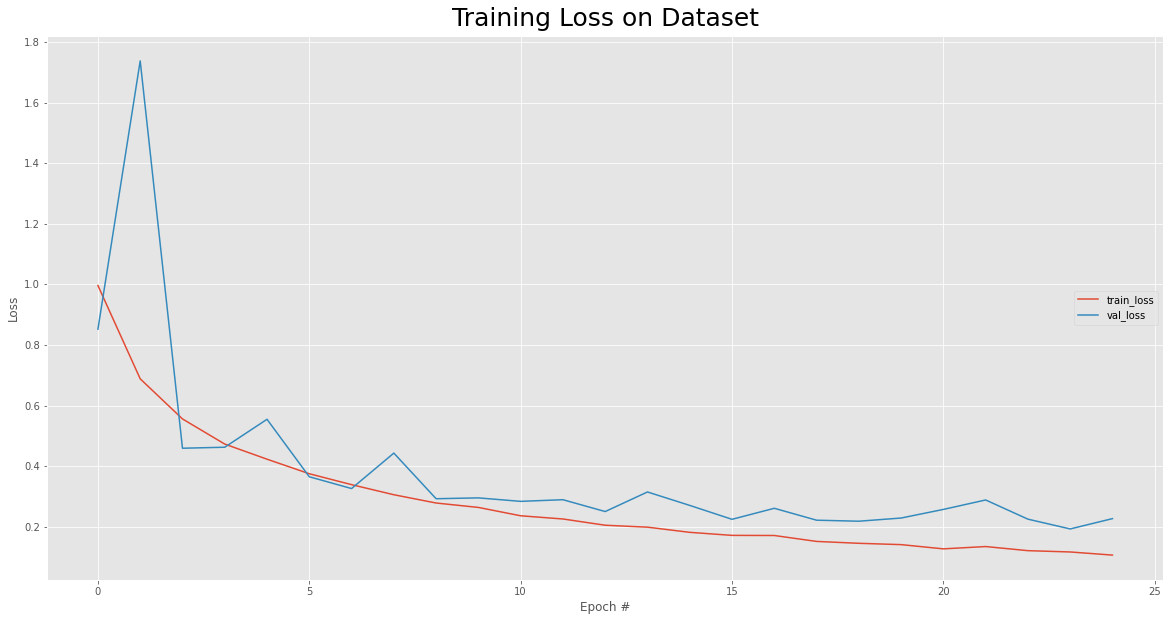

In [66]:
#@title
# plot the training loss and accuracy
plt.style.use("ggplot")

plt.figure(figsize=(20, 10))

plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"],   label="val_loss")

plt.title("Training Loss on Dataset", fontsize=25, pad=10)
plt.xlabel("Epoch #")
plt.ylabel("Loss")

plt.legend(loc="center right")
plt.show()

### 6.3) Plotting training progress (accuracy)

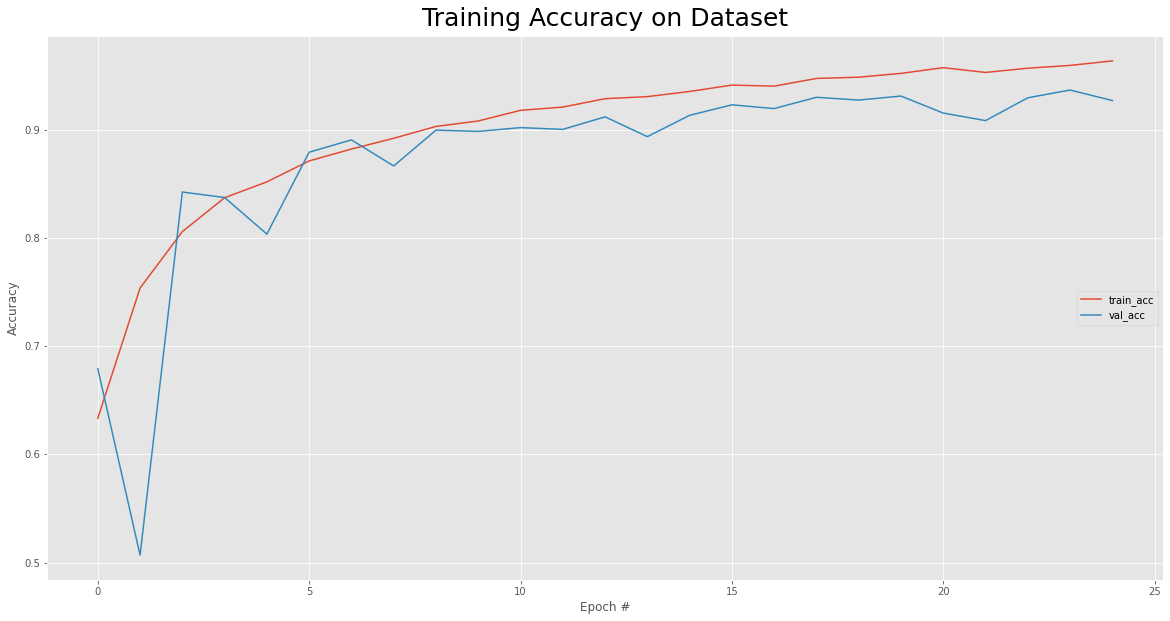

In [67]:
#@title
# plot the training accuracy
plt.style.use("ggplot")

plt.figure(figsize=(20, 10))

plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"],   label="val_acc")

plt.title("Training Accuracy on Dataset", fontsize=25, pad=10)
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")

plt.legend(loc="center right")
plt.show()

#-------------------------------------------------------------------------------

In [68]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

1828714
